# Tensor Factorization (multiple conditions)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/blob/main/docs/source/notebooks/tensor_factorization.ipynb)

This notebook shows how to find patterns of metabolic activities across multiple samples/conditions simultaneously. For this, we use a non-negative tensor factorization. Briefly, tensor factorization is an unsupervised approach that relies on data organized as tensors, in this case a 3D tensor where dimensions corresponds to samples/conditions, cell types, and metabolic tasks. If you are interested, we recommened reading [this review](https://doi.org/10.1016/j.cels.2024.07.004).

To illustrate this application application, the dataset we are using here includes [BALF samples from donors with varying severities of COVID-19](https://zenodo.org/record/7535867/files/BALF-COVID19-Liao_et_al-NatMed-2020.h5ad) [(Liao et al 2020)](https://doi.org/10.1038/s41591-020-0901-9).

## This tutorial includes following steps:
* [Loading libraries](#loading-libraries)
* [Loading COVID-19 data](#loading-covid-19-data)
* [Run scCellFie](#run-sccellfie)
* [Generate tensor](#generate-tensor)
* [Tensor factorization](#tensor-factorization)
* [Tensor factorization results](#tensor-factorization-results)

## Loading libraries <a class="anchor" id="loading-libraries"></a>

In [1]:
import pandas as pd
import numpy as np

import scanpy as sc
import sccellfie
import cell2cell as c2c

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import marsilea.plotter as mp
import marsilea as ma

import glasbey

/home/jovyan/my-conda-envs/single_cell/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
2025-09-03 18:44:11.561269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756925051.584280    1125 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756925051.591379    1125 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-03 18:44:11.619524: I tensorflow/core/platform/cpu_fea

In [2]:
import mpl_fontkit as fk
fk.install("Lato")
fk.set_font("Lato")

Font name: `Lato`


## Loading COVID-19 data <a class="anchor" id="loading-covid-19-data"></a>

We start loading our single-cell data. In this case, `adata.X` already contains raw counts, which are the main inputs of scCellFie.

In [3]:
adata = c2c.datasets.balf_covid('BALF-COVID19.h5ad')

## Run scCellFie <a class="anchor" id="run-sccellfie"></a>

Now we run scCellFie on the raw data.

In [4]:
batch_key = 'sample' # Specify batch_key or leave as None

In [5]:
results = sccellfie.run_sccellfie_pipeline(adata, # Raw counts
                                           organism='human',
                                           sccellfie_data_folder=None,
                                           n_counts_col='n_counts', # Column where total counts per cells are stored in adata.obs
                                           process_by_group=False, # Whether to do the processing by cell groups
                                           groupby=None, # Column indicating cell groups if `process_by_group=True`
                                           neighbors_key='neighbors', # Neighbors information if precomputed. Otherwise, it will be computed here
                                           n_neighbors=10, # Number of neighbors to use
                                           batch_key=batch_key, # None if batches are not included
                                           threshold_key='sccellfie_threshold', # This is for using the default database. If personalized thresholds are used, specificy column name
                                           smooth_cells=True, # Whether to perform gene expression smoothing before running the tool
                                           alpha=0.33, # Importance of neighbors' expression for the smoothing (0 to 1)
                                           chunk_size=5000, # Number of chunks to run the processing steps (helps with the memory)
                                           disable_pbar=False, 
                                           save_folder=None, # In case results will be saved. If so, results will not be returned and should be loaded from the folder (see sccellfie.io.load_data function
                                           save_filename=None # Name for saving the files, otherwise a default name will be used
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: human

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----


/home/jovyan/my-conda-envs/single_cell/lib/python3.10/site-packages/sccellfie/preprocessing/adata_utils.py:130: UserWarning: n_counts not found in adata.obs. Calculating total counts.
  warnings.warn(f"{n_counts_key} not found in adata.obs. Calculating total counts.", UserWarning)
/home/jovyan/my-conda-envs/single_cell/lib/python3.10/site-packages/sccellfie/preprocessing/adata_utils.py:151: UserWarning: Normalizing data.
  warnings.warn("Normalizing data.", UserWarning)



---- scCellFie Step: Computing neighbors ----


/home/jovyan/my-conda-envs/single_cell/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/jovyan/my-conda-envs/single_cell/lib/python3.10/site-packages/sccellfie/sccellfie_pipeline.py:414: FutureWarning: The specified parameters ('basis',) are no longer positional. Please specify them like `basis=True`
  sc.external.pp.harmony_integrate(bdata, batch_key, verbose)



---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 22
Shape of new adata object: (63103, 930)
Number of GPRs: 787
Shape of tasks by genes: (218, 930)
Shape of reactions by genes: (787, 930)
Shape of tasks by reactions: (218, 787)

---- scCellFie Step: Smoothing gene expression ----


Smoothing Expression: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]
/home/jovyan/my-conda-envs/single_cell/lib/python3.10/site-packages/sccellfie/expression/smoothing.py:188: ImplicitModificationWarning: Setting element `.layers['smoothed_X']` of view, initializing view as actual.
  adata.layers[key_added] = smoothed_matrix



---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----


Cell Rxn Activities: 100%|██████████| 63103/63103 [05:38<00:00, 186.58it/s]



---- scCellFie Step: Computing metabolic task activity ----
Removed 1 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


## Generate tensor <a class="anchor" id="generate-tensor"></a>

Once we have the results we can start generating the tensor for the factorization. However, we first need to preprocess the results.

### Min-max normalization

In this case, we min-max-normalize the metabolic task activities across single cells:

In [6]:
mt_original = results['adata'].metabolic_tasks.copy()

In [7]:
results['adata'].metabolic_tasks.X = np.clip((mt_original.X - mt_original.X.min (axis=0))/(mt_original.X.max(axis=0) - mt_original.X.min (axis=0)),
                                             a_min=0., 
                                             a_max=1.0)

### Tensor creation

Conveniently, scCellFie can be connected with cell2cell to handle tensors and perform the tensor factorization. This function below is designed to generate the inputs that cell2cell will use to generate a `PreBuiltTensor` object containing all the functions to perform our analysis:

In [8]:
tensor_data = sccellfie.external.sccellfie_to_tensor(results,
                                                     sample_key='sample_new',
                                                     celltype_key='celltype',
                                                     score_type='metabolic_tasks',
                                                     min_cells_per_group=5,
                                                     agg_func='trimean',
                                                     use_raw=False,
                                                     order_labels=None,
                                                     sort_elements=True,
                                                     context_order=None,
                                                     fill_value=np.nan,
                                                     verbose=True
                                                    )

Using metabolic_tasks with 217 features and 63103 cells
Aggregating metabolic_task scores using 'trimean' method...


Processing contexts: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Building tensor with dimensions:
  Contexts: 12
  Cell Types: 10
  Features: 217


Building tensor: 100%|██████████| 12/12 [00:00<00:00, 40.98it/s]


Tensor built successfully!
Shape: (12, 10, 217)
Non-zero elements: 19530
Fill value: nan


Next we use cell2cell to generate the tensor

In [9]:
tensor = c2c.tensor.PreBuiltTensor(**tensor_data)

### Tensor metadata

To plot the results later, we generate metadata useful for coloring tasks and samples/conditions by their major groups.

First, we generate groups for the metabolic tasks, based on the ``"System"`` column in the scCellFie database (``results['task_info']``):

In [10]:
task_mapper = results['task_info'].set_index('Task')['System'].to_dict()

In [11]:
met_functions = {task: task_mapper[task] for task in tensor.order_names[2]}

And for the samples, based on the disease condition (here, COVID-19 severity):

In [12]:
def context_mapper(context):
    if 'HC' in context: return 'Control'
    elif 'M' in context: return 'Moderate'
    elif 'S' in context: return 'Severe'
    else: return 'NA'

In [13]:
sample_groups = {context: context_mapper(context) for context in tensor.order_names[0]}

Then, create the metadata object:

In [14]:
meta_tf = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=[sample_groups, None, met_functions],
                                              fill_with_order_elements=True
                                             )

### Sort tensor elements by ordered categories

Then, based on this metadata, we can sort the tensor by the categories and their elements:

In [15]:
meta_tf[2].sort_values(['Category', 'Element'], inplace=True)

In [16]:
tensor = c2c.tensor.subset_tensor(tensor, subset_dict={2: meta_tf[2]['Element'].values.tolist()})

## Tensor factorization <a class="anchor" id="tensor-factorization"></a>

### Number of factors

**To select the number of factors** for the tensor factorization, we could do it either manually or automatically from an Elbow analysis.

By selecting the parameter ``automatic_elbow=True`` we automatically select the number of factors.

100%|██████████| 25/25 [01:39<00:00,  3.96s/it]

The rank at the elbow is: 6


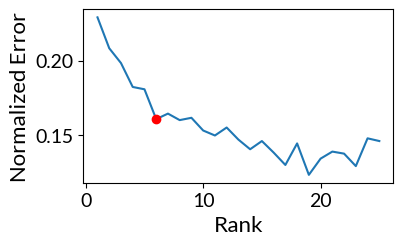

In [17]:
elbow, error = tensor.elbow_rank_selection(upper_rank=25,
                                           runs=1, # This can be increased for more robust results
                                           init='random',
                                           automatic_elbow=True,
                                           random_state=888,
                                          )


### Running tensor factorization

Since we are relying on cell2cell, this is easily implemented. In this case, it performs, by default, a *non-negative CANDECOMP/PARAFAC* tensor factorization:

In [18]:
tensor.compute_tensor_factorization(rank=tensor.rank,
                                    init='svd', 
                                    random_state=888)

Main results of the factorization can be found in ``tensor.tl_object`` and ``tensor.factors``. The latter is a dictionary containing the loadings for elements in each dimensions per factor, which are key to understand the identified patterns.

In [19]:
tensor.factors.keys()

odict_keys(['Contexts', 'Cell Types', 'Metabolic Tasks'])

## Tensor factorization results <a class="anchor" id="tensor-factorization-results"></a>


Again, cell2cell facilitates running the tensor factorization, but also visualizing results. We first start with bar plots for the loadings of each element across tensor dimensions:

### Bar plots

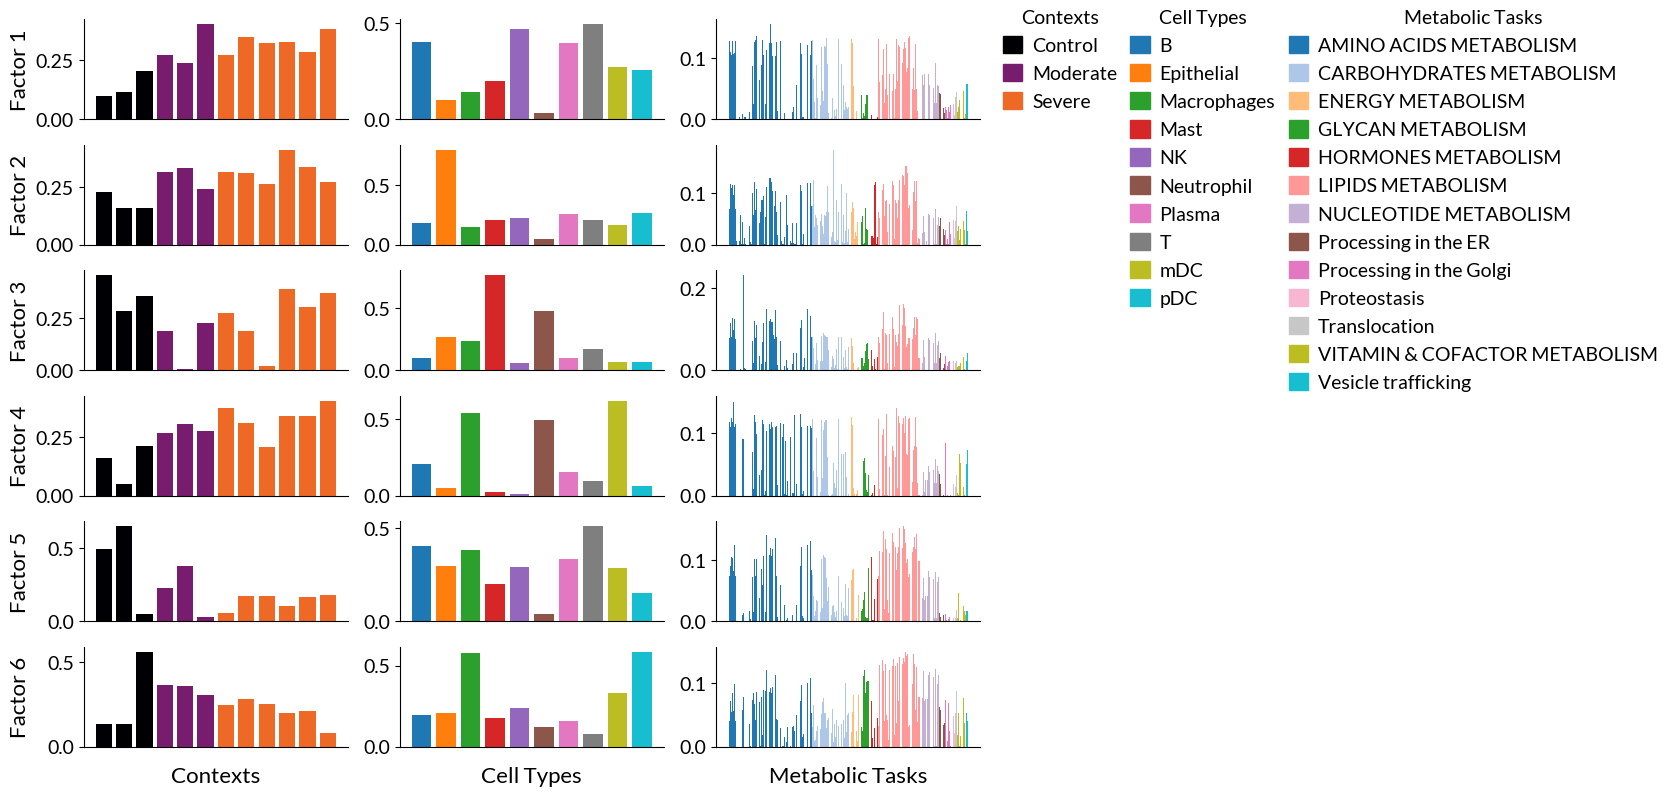

In [20]:
fig, ax = c2c.plotting.tensor_factors_plot(tensor, metadata=meta_tf, meta_cmaps=['inferno', 'tab10', 'tab20'], fontsize=14, filename='BarPlots-Factors-MetabolicTasks.pdf')

### Top metabolic tasks

We can also obtain the top tasks for each factor (sorted by their loadings):

In [21]:
for i in range(1, tensor.rank+1):
    print(tensor.get_top_factor_elements('Metabolic Tasks', factor_name=f'Factor {i}', top_number=5))
    print('')

Methionine degradation        0.155069
Arachidonate synthesis        0.141260
Glutamine degradation         0.136161
Synthesis of palmitoyl-CoA    0.134918
Synthesis of malonyl-coa      0.132144
Name: Factor 1, dtype: float64

Link between glyoxylate metabolism and pentose phosphate pathway (Xylulose to glycolate)    0.185962
Synthesis of globoside (link with globoside metabolism)                                     0.153227
Synthesis of galactosyl glucosyl ceramide (link with ganglioside metabolism)                0.153225
Synthesis of glucocerebroside                                                               0.140957
Phosphatidyl-inositol synthesis                                                             0.136437
Name: Factor 2, dtype: float64

Conversion of glutamate to glutamine    0.230501
Phosphatidyl-serine synthesis           0.159930
Phosphatidyl-ethanolamine synthesis     0.159077
Phosphatidyl-choline synthesis          0.158241
Sphingomyelin synthesis                 

### Heatmaps

Then, we can select metabolic tasks with the higher loadings by setting thresholds:

In [22]:
df = tensor.factors['Metabolic Tasks']

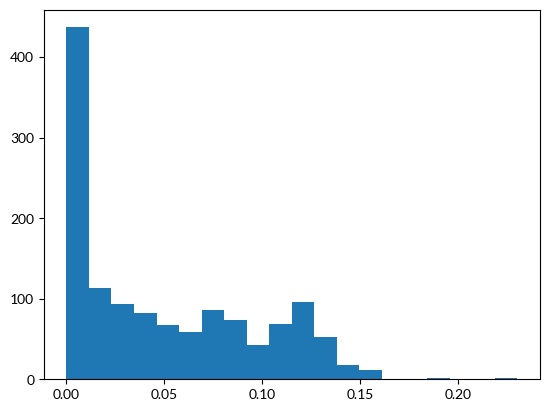

In [23]:
_ = plt.hist(df.values.flatten(), bins = 20)

In [24]:
loading_threshold = 0.125

With these thresholds, we can plot the high-loading metabolic tasks across factors. In addition we can visualize the key cells types to have an idea of what are the patterns capturing.

In this case we rely con [Marsilea](https://marsilea.readthedocs.io/) for the visualizations:

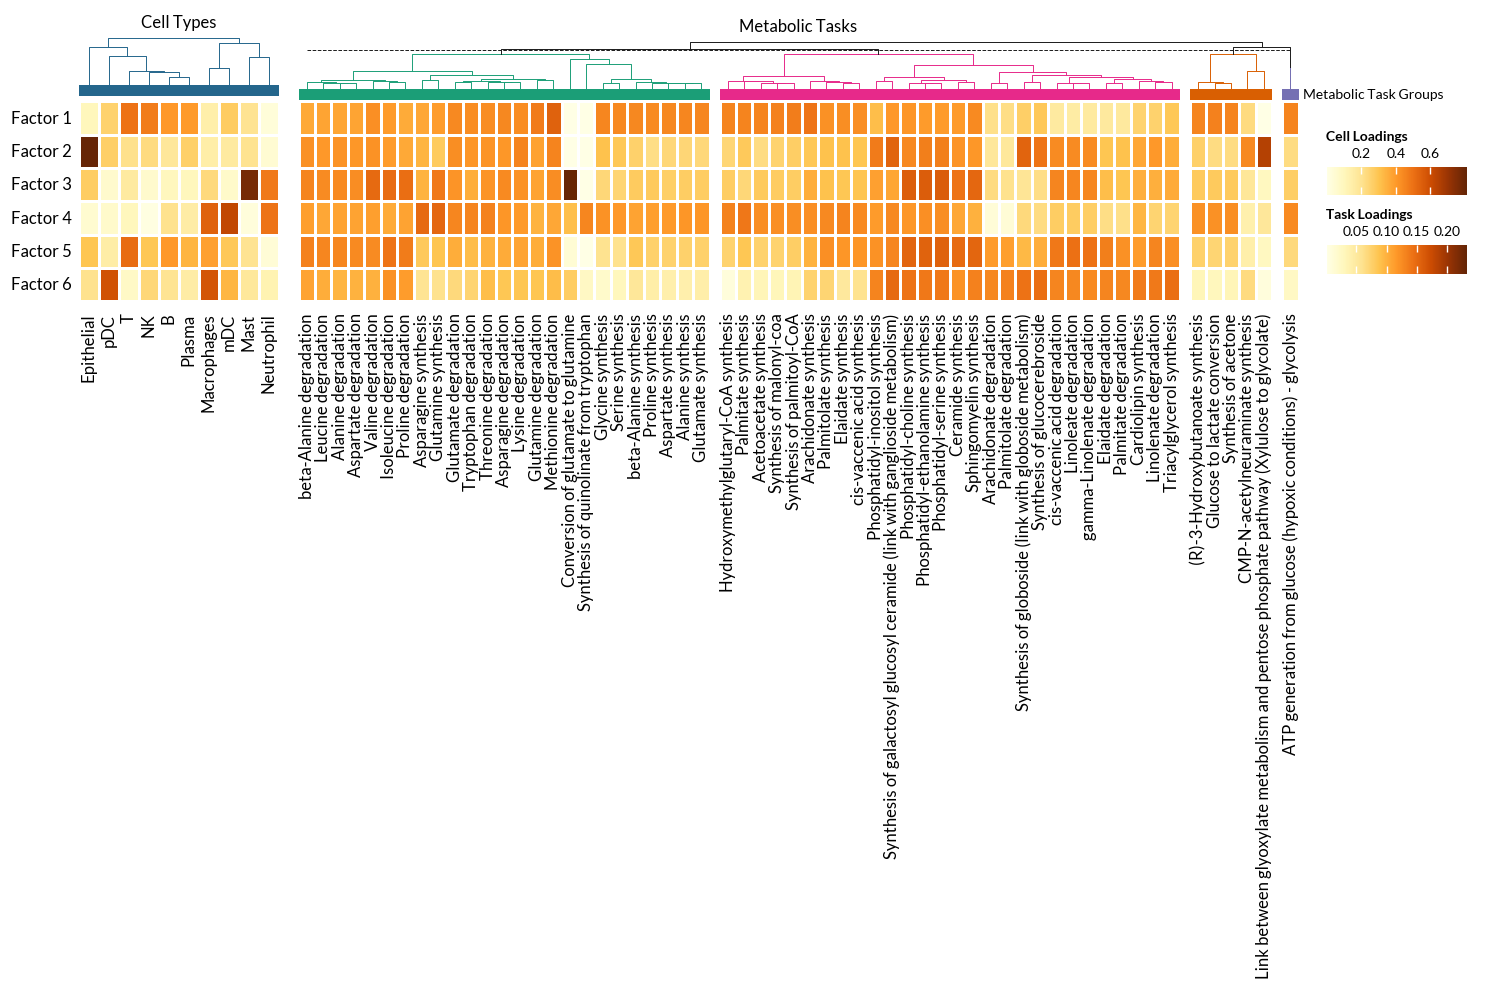

In [27]:
fontsize = 12

## CELL TYPES HEATMAP
# Data
df_plot = tensor.factors['Cell Types'].T
data = df_plot.values
vlimit = np.max(np.abs(data))

h1 = ma.Heatmap(data, linewidth=1, vmin=0, vmax=vlimit, height=2, width=2, cmap='YlOrBr',
               cbar_kws={'title' : 'Cell Loadings', 'orientation' : 'horizontal'}, 
              )
h1.add_left(mp.Labels(list(df_plot.index), fontsize=fontsize), pad=.05)
h1.add_bottom(mp.Labels(list(df_plot.columns), fontsize=fontsize, rotation=90), pad=.1)
h1.add_top(mp.Chunk([''], ['#24668C'], fontsize=fontsize-2, rotation=0, ha='center'), pad=0.05, name='Groups', legend=True)
h1.add_dendrogram("top", method='ward', metric='euclidean', colors=['#24668C'])
h1.add_title('Cell Types')

## METABOLIC TASKS HEATMAP
# Data
df_plot = df[(df.T > loading_threshold).any()].T
data = df_plot.values
vlimit = np.max(np.abs(data))

# Task grouping
task_categories = [task_mapper[t] for t in df_plot.columns]
task_cats = sorted(set(task_categories))
palette = glasbey.extend_palette('Dark2', palette_size=max(len(task_cats), 10))

h2 = ma.Heatmap(data, linewidth=1, vmin=0, vmax=vlimit, height=2, width=10, cmap='YlOrBr',
               cbar_kws={'title' : 'Task Loadings', 'orientation' : 'horizontal'}, 
              )
h2.group_cols(task_categories, order=task_cats)
#h2.add_left(mp.Labels(list(df_plot.index), fontsize=fontsize), pad=.05)
h2.add_top(mp.Chunk(len(task_cats)*[''], palette, fontsize=fontsize-2, rotation=0,
                    label='Metabolic Task Groups'), pad=0.01, name='Groups', legend=True)
h2.add_dendrogram("top", method='ward', metric='euclidean', colors=palette)
h2.add_bottom(mp.Labels(list(df_plot.columns), fontsize=fontsize, rotation=90), pad=.1)
h2.add_title('Metabolic Tasks')
h = (h1 + 0.2 + h2)
h.add_legends(stack_size=3, stack_by='col')
h.render()
h.save('Heatmap-Factors-MetabolicTasks.pdf', dpi=300)